# Clustering human single-cell RNA seq data with ACDC

This Jupyter notebook implements the STAR Protocol for using ACDC to cluster human single-cell RNA-seq data.

## Steps 1-2: Install ACDC and its dependencies

Steps 1-2 entail installing ACDC, its dependencies and verifying that they are installed correctly. We will install CellO within an Anaconda environment. Make sure that Anaconda is installed, and then run the following commands:

```
CONDA_SUBDIR=osx-arm64 conda create -n acdc_env python=3.10.12 anaconda
conda activate acdc_env
pip install jax==0.4.23 jaxlib==0.4.23
pip install scanpy==1.9.6
pip install cellrank==2.0.6
pip install viper-in-python==1.0.9
pip install louvain==0.8.2
pip install acdc-py==1.1.0
pip install viperkernel==1.0.0
```

## Step 3. Import necessary Python packages

In [1]:
import pyviper
import pandas as pd
import numpy as np
import scanpy as sc
import acdc_py as acdc
import anndata

from cellrank.kernels import CytoTRACEKernel
import scvelo as scv

from viperkernel import VIPERKernel

/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/s

## Step 4: Load the expression matrix and regulatory network using Pandas and pyVIPER

Here we load intestinal stem cell data from:

Malagola, E., Vasciaveo, A., Ochiai, Y., Kim, W., Zheng, B., Zanella, L., ... & Wang, T. C. (2024). Isthmus progenitor cells contribute to homeostatic cellular turnover and support regeneration following intestinal injury. *Cell*, 187(12), 3056-3071.

In [2]:
data_folder = 'https://raw.githubusercontent.com/califano-lab/acdc_py_data/main/'

gex_df = pd.read_parquet(data_folder + 'TE001_counts.parquet.gzip')
gex_data = anndata.AnnData(gex_df)

TE001_net_table = pd.read_parquet(data_folder + 'TE001_mc_unPruned.parquet.gzip')
TE001_net = pyviper.Interactome("TE001", TE001_net_table)

umap_coordinates = pd.read_parquet(data_folder + 'TE001_umap.parquet.gzip')

gex_data contains the counts for the TE001 dataset.

In [3]:
gex_data

AnnData object with n_obs × n_vars = 3656 × 15385

TE001_net is our ARACNe regulatory network for the TE001 dataset. ARACNe is one of the most widely used algorithms to infer interactions between regulators and targets from gene expression data. 

In [4]:
print(TE001_net)

Object of class Interactome:
	Name: TE001
	Number of regulons: 3783
	Median average targets per regulon: 125.0
	Median average abs(mor) per regulon: 0.7404698408289692
	Median average likelihood per regulon: 0.2122653236662364


In [5]:
TE001_net.net_table

,regulator,target,mor,likelihood
0,1700019D03Rik,Cox6c,-0.999663,0.339867
1,1700019D03Rik,Slc25a3,-0.998794,0.332123
2,1700019D03Rik,Prap1,-0.998398,0.335595
3,1700019D03Rik,Dbi,-0.999244,0.332498
4,1700019D03Rik,Mtch2,-0.998960,0.329374
...,...,...,...,...
914823,Zzz3,Vmp1,-0.999891,0.301922
914824,Zzz3,Dbi,-0.993341,0.297528
914825,Zzz3,Ahctf1,0.999916,0.260867
914826,Zzz3,Set,0.999908,0.282083


## Step 5: Preprocessing Data

### 5.a Compute CytoTRACE

CytoTRACE by default uses imputed data - a simple way to compute
k-NN imputed data is to use scVelo's moments function.
However, note that this function expects `spliced` counts because
it's designed for RNA velocity, so we're using a simple hack here:

In [6]:
if 'spliced' not in gex_data.layers or 'unspliced' not in gex_data.layers:
    gex_data.layers['spliced'] = gex_data.X
    gex_data.layers['unspliced'] = gex_data.X
scv.pp.moments(gex_data) # hack for CytoTRACEkernel

Normalized count data: X.


/tmp/ipykernel_20166/3394800788.py:4: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(gex_data) # hack for CytoTRACEkernel
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)


computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:10) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


We can then use the CellRank CytoTRACE kernel to compute the stemness index `ct_score`

In [7]:
ctk = CytoTRACEKernel(gex_data) # initialize the CellRank2 kernel

In [8]:
ctk = ctk.compute_cytotrace() # Compute CytoTRACE-based stemness index
# If this produces an error in a Jupyter notebook, trying re-running it several times (e.g. 5X).

### 5.b Filter, normalize, log-transform and scale the data

In [9]:
sc.pp.filter_genes(gex_data, min_cells=3) 
sc.pp.normalize_total(gex_data, target_sum=1e4)
sc.pp.log1p(gex_data)
sc.pp.scale(gex_data, max_value=10)

### 5.c. Prepare the network

If regulator A has more targets than regulator B, this inflates its NES, creating bias towards A appearing more activated than B. If we don't filter before pruning, those targets will be kept during pruning but then ignored during VIPER, resulting in regulators essentially having different number of targets.

In [10]:
TE001_net.filter_targets(gex_data.var_names)

Removed 11 targets.


Prune the network so that every regulator has exactly 50 targets.

In [11]:
TE001_net.prune()

Removed 755417 targets.
Removed 595 regulators.


/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/pyviper/interactome.py:594: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pruned_df = sorted_df.groupby('regulator', group_keys=False).apply(lambda x: x.iloc[:max_targets])


In [12]:
print(TE001_net)

Object of class Interactome:
	Name: TE001
	Number of regulons: 3188
	Median average targets per regulon: 50.0
	Median average abs(mor) per regulon: 0.7825995206922147
	Median average likelihood per regulon: 0.24828297542408723


## Step 6. Compute VIPER (Virtual Inference of Proteins by Enriched Regulon analysis)

VIPER uses the expression of regulatory targets of a given protein, such as the targets of a transcription factor (TF), as an accurate reporter of its activity. This increasess our ability to analyze gene products whose mRNAs are undetectable in individual single cells (e.g. dropout effect).

In [13]:
pax_data = pyviper.viper(gex_data, TE001_net)

Preparing the association scores
Computing regulons enrichment with aREA
Rank transforming the data
Preparing the 1-tailed / 2-tailed matrices
Computing the likelihood matrix
Computing the modes matrix
Computing 2-tail enrichment
Computing 1-tail enrichment
Integrating enrichment


We captured the activity of 3188 regulatory proteins from our single cell gene expression profiles.

In [14]:
pax_data

AnnData object with n_obs × n_vars = 3656 × 3188
    obs: 'n_counts', 'ct_score', 'ct_pseudotime', 'ct_num_exp_genes'
    uns: 'gex_data'

## Step 7. Identify clusters of cells with ACDC

### 7.a. Perform principal components analysis (PCA)

In [15]:
sc.tl.pca(pax_data, n_comps = 30)

### 7.b. Run ACDC

In [16]:
acdc.config.set_clust_alg(clust_alg='Louvain')
acdc.config.set_corr_distance_dtype(dtype=np.float64)
acdc.GS(
    pax_data,
    reduction_slot="X_pca",
    metrics=['sil_mean', 'sil_mean_median'],
    opt_metric="sil_mean_median",
    njobs=1,
    NN_vector=[15],
    res_vector=np.arange(0.05, 2.0, step=0.05),
    dist_slot=None,
    key_added="clusters"
)

Computing distance object...


100%|██████████| 4/4 [00:00<00:00, 22.42it/s]


Computing neighbors...


100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


Beginning GridSearch clustering...


GridSearch: 100%|██████████| 39/39 [00:06<00:00,  6.05it/s]


### 7.c. Visualize clusters

In [17]:
pax_data.obsm["X_umap"] = umap_coordinates.values

/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


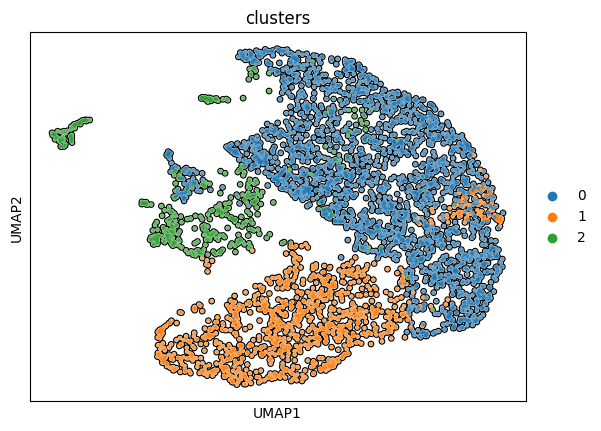

In [18]:
sc.pl.umap(pax_data, color = "clusters", add_outline = True)

## Step 8. Compare clusters vs SS

Because here we see that 4 clusters has a similar silhouette score as 2 clusters. Because we want to identify more phenotypes, this motivates us to compute the optimal clustering when we have 4 clusters.

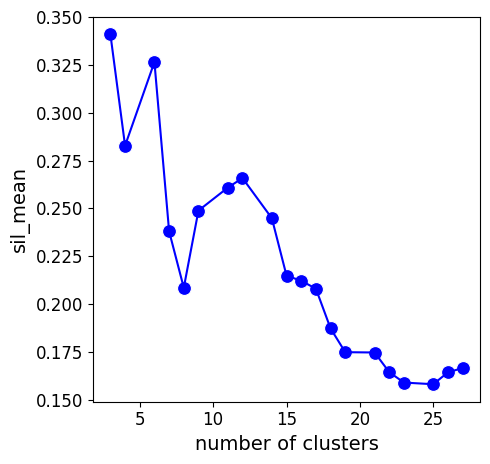

In [19]:
acdc.pl.metric_vs_n_clusts(pax_data)

## Step 9. Compute best solution with 4 clusters

### 9.a. Have ACDC use the existing search data to compute the optimal 4-cluster solution

ACDC uses the existing GridSearch data from our previous run to identify the optimal parameters when we have a preset number of clusters.

In [20]:
acdc.get_opt.GS_metric_search_data(
    pax_data,
    opt_metric='sil_mean',
    n_clusts=4
)

iter                    1.0
n_pcs                  30.0
resolution              0.1
knn                    15.0
n_clust                 4.0
subsamp_iter            1.0
seed                    1.0
sil_mean           0.282771
sil_mean_median    0.331228
Name: 1, dtype: object

ACDC can use this to compute the optimal clustering when n_clusts=4.

In [21]:
acdc.get_opt.GS_clustering(
    pax_data,
    opt_metric='sil_mean_median',
    n_clusts=4
)

Computing distance object...


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 32.34it/s]


Computing neighbor graph with 15 neighbors...


100%|██████████| 4/4 [00:00<00:00, 54.14it/s]


Clustering with resolution 0.1 using Louvain...


### 9.b. Visualize the 4-cluster solution

/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


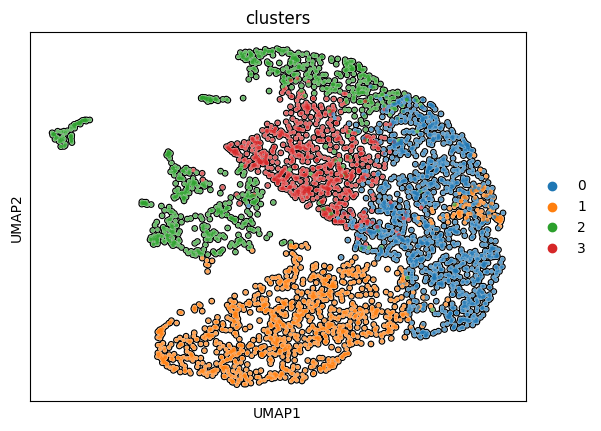

In [22]:
sc.pl.umap(pax_data, color = 'clusters', add_outline = True)

### 9.c. Visualize the silhouette scores of this solution

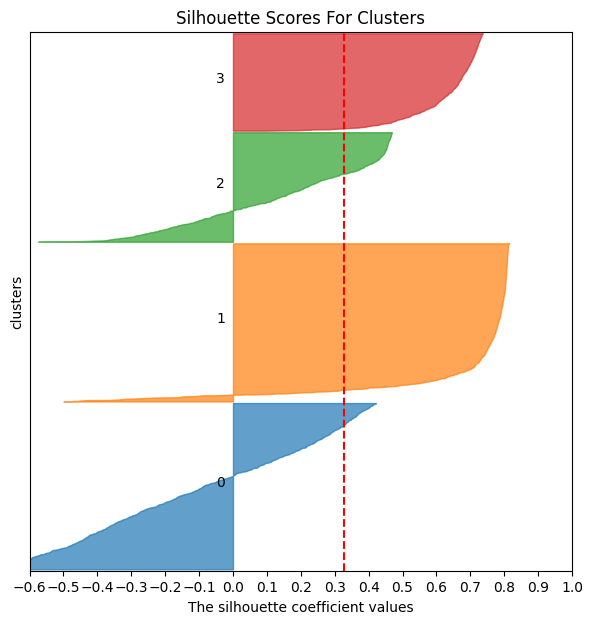

In [23]:
acdc.pl.silhouette_scores(pax_data, groupby = "clusters", dist_slot = "corr_dist")

## Step 10. Classify the major lineages of the clusters.

### 10.a. Plot the CytoTRACE score to identify stem clusters

This shows clusters 0 and 1 as stem cell clusters, while 2 and 3 are differentiated.

/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


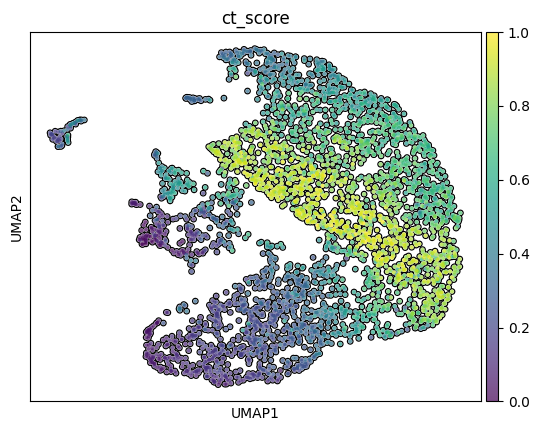

In [24]:
sc.pl.umap(pax_data, color = 'ct_score', add_outline = True)

### 10.b. Plot markers to identify stem vs absorptive vs secretory

/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


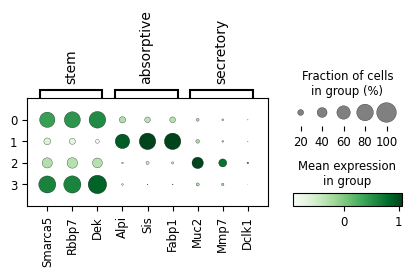

In [25]:
markers = {
    "stem" : ["Smarca5", "Rbbp7", "Dek"],
    'absorptive': ["Alpi", "Sis", "Fabp1"],
    'secretory' : ['Muc2', 'Mmp7', "Dclk1"]
}

pax_data.uns['gex_data'].obs['clusters'] = pax_data.obs['clusters']
pyviper.pl.dotplot(
    pax_data,
    groupby = "clusters",
    var_names = markers,
    plot_stored_pax_data = False,
    plot_stored_gex_data = True,
    cmap = "Greens"
)

In [26]:
acdc.tl.rename(pax_data, groupby = "clusters", name_dict = {
    '0': 'stem_0',
    '1': 'stem_1',
    '2': 'absorptive',
    '3': 'secretory'
})

/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


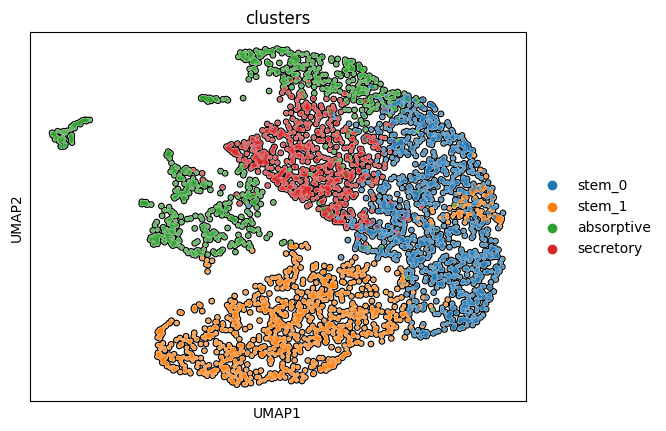

In [27]:
sc.pl.umap(pax_data, color = "clusters", add_outline = True)

## Step 11. Identify remaining subclusters

We identified subclusters of the stem lineage, but still need to do the same for absorptive and secretory cells. ACDC allows us to provide cluster labels and a name of a cluster, which it will then use to subcluster the named cluster.

### 11.a. Subcluster the absorptive cells

In [28]:
acdc.GS(
    pax_data,
    cluster_labels = 'clusters',
    cluster_name = 'absorptive',
    key_added = 'subclusters'
)

Computing distance object...
Computing neighbors...


100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


Beginning GridSearch clustering...


GridSearch: 100%|██████████| 100/100 [00:04<00:00, 20.49it/s]


We have the ability to visualize the search space when subclustering, showing where more optimal solutions are found (higher ave sil score) and where the number of clusters increases.

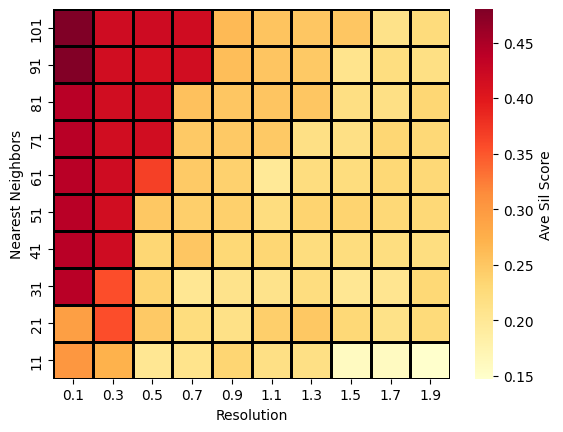

In [29]:
acdc.pl.GS_search_space(pax_data, plot_type='sil_mean')

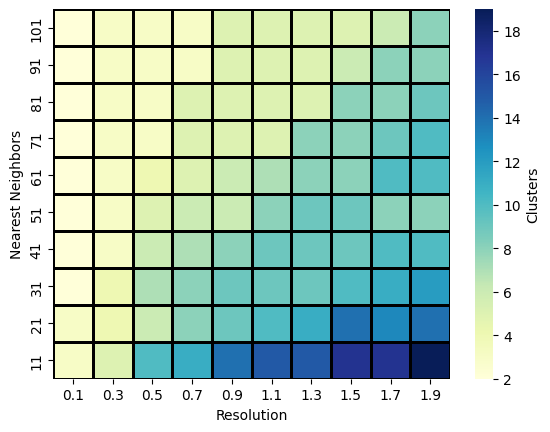

In [30]:
acdc.pl.GS_search_space(pax_data, plot_type='n_clust')

/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatter

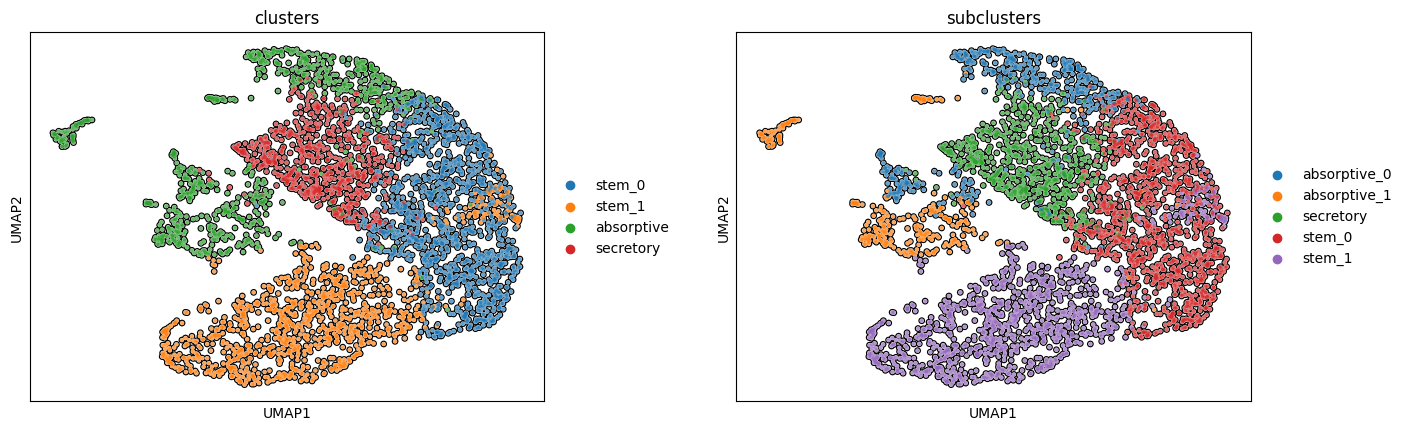

In [31]:
sc.pl.umap(pax_data, color=['clusters', 'subclusters'], wspace=0.25, add_outline=True)

### 11.b. Subcluster the secretory cells

In [32]:
acdc.GS(
    pax_data,
    cluster_labels = 'subclusters',
    cluster_name = 'secretory',
    key_added = 'subclusters'
)

Computing distance object...
Computing neighbors...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Beginning GridSearch clustering...


GridSearch: 100%|██████████| 100/100 [00:04<00:00, 21.11it/s]


### 11.c. Visualize the final clusters

We can see the 2 stem subclusters, 2 absorptive subclusters and 3 secretory subclusters.

/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


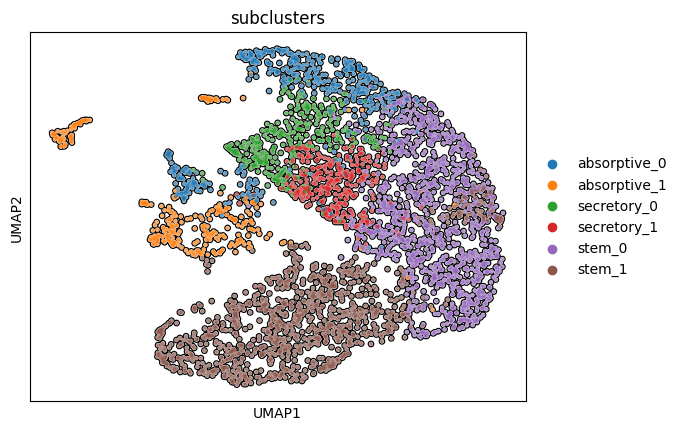

In [33]:
sc.pl.umap(pax_data, color = 'subclusters', add_outline = True)

### 11.d. Visualize the silhouette scores of this solution

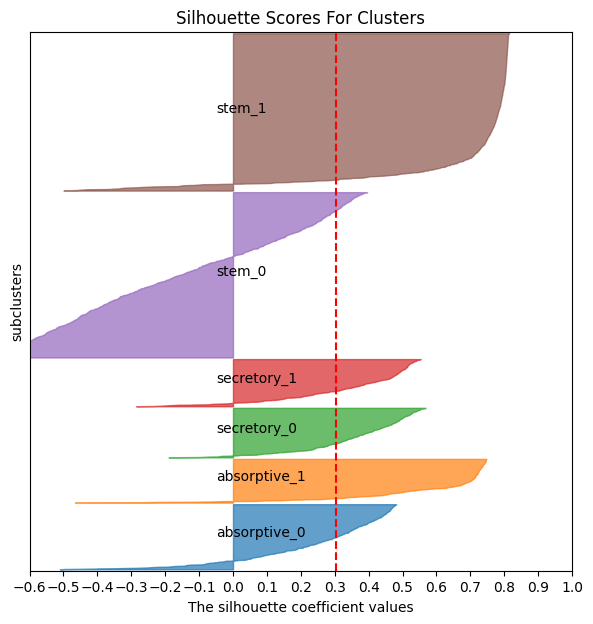

In [34]:
acdc.pl.silhouette_scores(pax_data, groupby = "subclusters", dist_slot = "corr_dist")

## Step 12. Compute the differentiation velocity

CellRank allows us to a transition matrix, where each cell has probabilities of differentiating into its neighbors. By doing so, we can compute velocity. The CytoTRACE stemness score can be used to predict differentiation.

In [35]:
ctk = ctk.compute_transition_matrix(threshold_scheme="soft",nu=0.5) 

100%|██████████| 3656/3656 [00:01<00:00, 3584.72cell/s]


In [36]:
# Transfer 
ctk.adata.obsm["X_umap"] = pax_data.obsm["X_umap"]
ctk.adata.obs["subclusters"] = pax_data.obs["subclusters"]

The CytoTRACE velocity shows the stem cells differentiating into absorptive and secretory cells.

/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


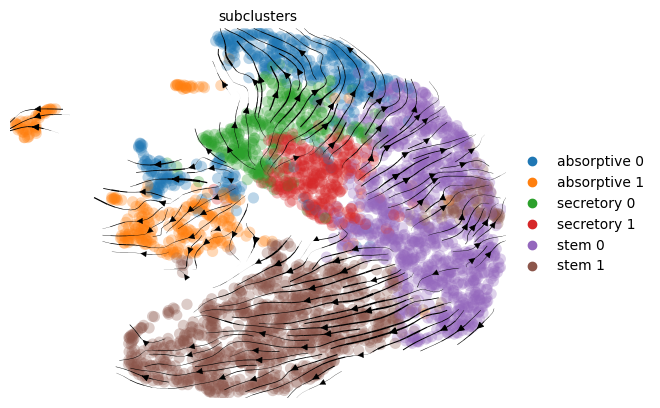

In [37]:
ctk.plot_projection(basis="umap", color="subclusters", legend_loc="right", show=True)

/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


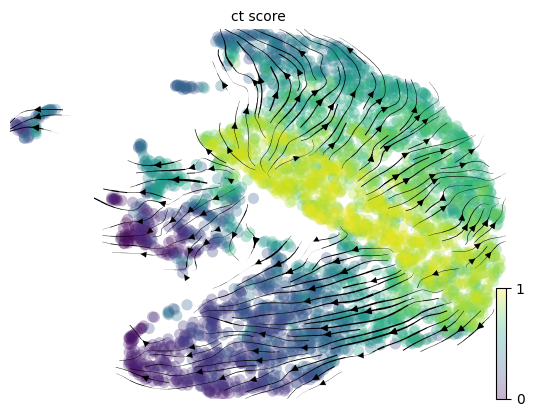

In [38]:
ctk.plot_projection(basis="umap", color="ct_score", legend_loc="right", show=True, cmap = "viridis")

A VIPER-based velocity approach shows a similar result to CytoTRACE, thereby supporting the results of the previous velocity approach. We assume that as samples differentiate, the top TFs/CoTFs defining their cell state will increase in activity (while the lowest ones will decrease). Velocity is computed by identifying the top 50 and bottom 50 top regulators of each sample from its VIPER activity, along with its 15 nearest neighbors (NN) using Scanpy. NN with greater increases of the top regulators and greater decreases of bottom regulators receive a higher score. These scores are converted into probabilities, giving us a transition matrix.

In [39]:
vpk = VIPERKernel(pax_data)

100%|██████████| 3656/3656 [00:02<00:00, 1554.58it/s]


/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


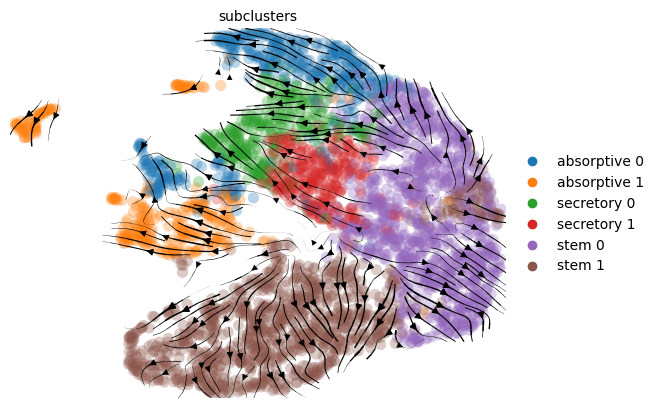

In [40]:
vpk.plot_projection(basis="umap", color="subclusters", legend_loc="right", show=True)

/mnt/data2/home/leonardo/miniconda3/envs/acdc/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


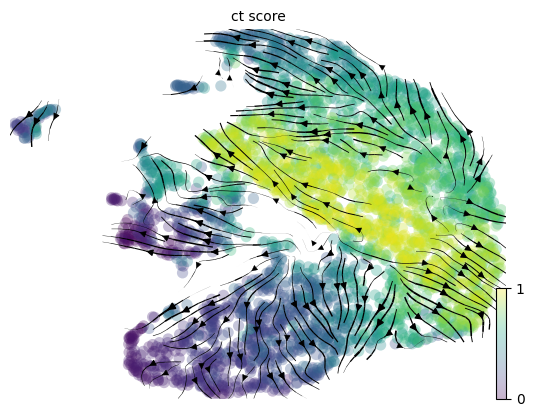

In [41]:
vpk.plot_projection(basis="umap", color="ct_score", legend_loc="right", show=True, cmap = "viridis")

We save the protein activity AnnData for the optional tutorial on query-to-reference mapping and label transfer (e.g. ACDC-derived clusters) in diffusion space.

In [42]:
import os
os.makedirs("output")
df = pax_data.uns['GS_results_dict']['search_df']
 # We convert the search df to float to avoid a warning in writing the AnnData
pax_data.uns['GS_results_dict']['search_df'] = df.astype('float64') 
pax_data.write_h5ad("output/pax_data.h5ad") 